In [1]:
from easydict import EasyDict
from utils.metrics import masked_mae
from data.data_read import read_npz
from config.cfg_general import CFG_GENERAL
import os,torch,time
import torch.nn as nn
from utils.logger import init_tensorboard,init_logger
from utils.checkpoint import resume_model
from runner.builder import build_model
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from utils.checkpoint import save_best_model,save_model
from utils.meter_pool import MeterPool
from runner.builder import build_meter,curriculum_learning
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

out_dir = "./checkpoints"
epochs = 10
val_interval = 1
ds = "PEMS08"
algo = "SIDLinear"
result_total = {}

dataset_args = EasyDict({'NAME': 'PEMS08',
                'NUM_NODES': 170,
                'STEPS_PER_DAY': 288,
                'READ_DATA_FUNC': read_npz,
                'TOD': True,
                'DOW': True,
                'DOM': False,
                'DOY': False,
                'OUTPUT_DIR': 'datasets/PEMS08',
                'DATA_FILE_PATH': 'datasets/raw_data/PEMS08/PEMS08.npz',
                'GRAPH_FILE_PATH': 'datasets/raw_data/PEMS08/adj_PEMS08.pkl'})

ckpt_save_dir = "./checkpoints/PEMS08_SIDLinear_10"
if not os.path.isdir(ckpt_save_dir):
    os.makedirs(ckpt_save_dir)

logger = init_logger(f"{ds}_{algo}_{epochs}",ckpt_save_dir)
tensbd = init_tensorboard(ckpt_save_dir)

build datasets

In [2]:
def re_standard_transform(data, **kwargs):
    mean, std = kwargs["mean"], kwargs["std"]
    if isinstance(mean, np.ndarray):
        mean = torch.from_numpy(mean).type_as(data).to(data.device).unsqueeze(0)
        std = torch.from_numpy(std).type_as(data).to(data.device).unsqueeze(0)
    data = data * std
    data = data + mean
    return data

def standard_transform(data: np.array, train_index, norm_each_channel = False):
    data_train = data[:train_index[-1][1], ...]
    if norm_each_channel:
        mean, std = data_train.mean(axis=0, keepdims=True), data_train.std(axis=0, keepdims=True)
    else:
        mean, std = data_train[..., 0].mean(), data_train[..., 0].std()

    print("mean (training data):", mean)
    print("std (training data):", std)
    scaler = {}
    scaler["func"] = re_standard_transform.__name__
    scaler["args"] = {"mean": mean, "std": std}


    def normalize(x):
        return (x - mean) / std

    data_norm = normalize(data)
    return data_norm,scaler

class TsDataset(Dataset):
    def __init__(self, processed_data, index):
        super().__init__()
        self.data = torch.from_numpy(processed_data).float()
        self.index = index

    def __getitem__(self, index: int) -> tuple:

        idx = list(self.index[index])
        if isinstance(idx[0], int):
            # continuous index
            history_data = self.data[idx[0]:idx[1]]
            future_data = self.data[idx[1]:idx[2]]
        else:
            # discontinuous index or custom index
            # NOTE: current time $t$ should not included in the index[0]
            history_index = idx[0]    # list
            assert idx[1] not in history_index, "current time t should not included in the idx[0]"
            history_index.append(idx[1])
            history_data = self.data[history_index]
            future_data = self.data[idx[1], idx[2]]

        return future_data, history_data

    def __len__(self):
        return len(self.index)
    
cfg_dataset = dataset_args
cfg_general = CFG_GENERAL
args = dataset_args.copy()
args.update(CFG_GENERAL.DATASET)
datasets={}


target_channel = args.get("TARGET_CHANNEL",[0])
future_seq_len = args["FUTURE_SEQ_LEN"]
history_seq_len = args["HISTORY_SEQ_LEN"]
train_ratio = args["TRAIN_RATIO"]
valid_ratio = args["VALID_RATIO"]
data_file_path = args["DATA_FILE_PATH"]
norm_each_channel = args["NORM_EACH_CHANNEL"]
graph_file_path = args.get("GRAPH_FILE_PATH",None)
steps_per_day = args.get("STEPS_PER_DAY",None)
add_time_of_day = args.get("TOD",True)
add_day_of_week = args.get("DOW",True)
add_day_of_month = args.get("DOM",False)
add_day_of_year = args.get("DOY",False)

if_rescale = not norm_each_channel 


# read data
data,df_index = args["READ_DATA_FUNC"](data_file_path,target_channel)
print("raw time series shape: {0}".format(data.shape))

# split data
l, n, f = data.shape
num_samples = l - (history_seq_len + future_seq_len) + 1
train_num = round(num_samples * train_ratio)
valid_num = round(num_samples * valid_ratio)
test_num = num_samples - train_num - valid_num
print("number of training samples:{0}".format(train_num))
print("number of validation samples:{0}".format(valid_num))
print("number of test samples:{0}".format(test_num))

index_list = []
for t in range(history_seq_len, num_samples + history_seq_len):
    index = (t-history_seq_len, t, t+future_seq_len)
    index_list.append(index)

train_index = index_list[:train_num]
valid_index = index_list[train_num: train_num + valid_num]
test_index = index_list[train_num + valid_num : train_num + valid_num + test_num]

# normalize data
data_norm,scaler = standard_transform(data, train_index, norm_each_channel=norm_each_channel)

period = 600
cycle = []
for i in range(period):
    cycle.append(data_norm[i:train_num:period,:,:].mean(axis=0))

cycle = np.array(cycle*(data_norm.shape[0]//period)+cycle[:data_norm.shape[0]%period])

# add temporal feature
feature_list = [data_norm,cycle]
if add_time_of_day:
    # numerical time_of_day
    if steps_per_day is None:
        tod = (df_index.values - df_index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
    else:
        tod = [i % steps_per_day / steps_per_day for i in range(data_norm.shape[0])]
        tod = np.array(tod)
    tod_tiled = np.tile(tod, [1, n, 1]).transpose((2, 1, 0))
    feature_list.append(tod_tiled)

if add_day_of_week:
    # numerical day_of_week
    if steps_per_day is None:
        dow = df_index.dayofweek / 7
    else:
        dow = [(i // steps_per_day) % 7 / 7 for i in range(data_norm.shape[0])]
        dow = np.array(dow)
    dow_tiled = np.tile(dow, [1, n, 1]).transpose((2, 1, 0))
    feature_list.append(dow_tiled)

if add_day_of_month:
    # numerical day_of_month
    dom = (df_index.day - 1 ) / 31 # df.index.day starts from 1. We need to minus 1 to make it start from 0.
    dom_tiled = np.tile(dom, [1, n, 1]).transpose((2, 1, 0))
    feature_list.append(dom_tiled)

if add_day_of_year:
    # numerical day_of_year
    doy = (df_index.dayofyear - 1) / 366 # df.index.month starts from 1. We need to minus 1 to make it start from 0.
    doy_tiled = np.tile(doy, [1, n, 1]).transpose((2, 1, 0))
    feature_list.append(doy_tiled)

processed_data = np.concatenate(feature_list, axis=-1)

ds_train = TsDataset(processed_data,train_index)
datasets["train"] = DataLoader(ds_train,
                                collate_fn  =cfg_general.TRAIN.get('COLLATE_FN', None),
                                batch_size  =cfg_general.TRAIN.get('BATCH_SIZE', 1),
                                shuffle     =cfg_general.TRAIN.get('SHUFFLE', False),
                                num_workers =cfg_general.TRAIN.get('NUM_WORKERS', 0),
                                pin_memory  =cfg_general.TRAIN.get('PIN_MEMORY', False))

ds_val = TsDataset(processed_data,valid_index)
datasets["val"] = DataLoader(ds_val,
                                collate_fn  =cfg_general.VAL.get('COLLATE_FN', None),
                                batch_size  =cfg_general.VAL.get('BATCH_SIZE', 1),
                                shuffle     =cfg_general.VAL.get('SHUFFLE', False),
                                num_workers =cfg_general.VAL.get('NUM_WORKERS', 0),
                                pin_memory  =cfg_general.VAL.get('PIN_MEMORY', False))

ds_test = TsDataset(processed_data,test_index)
datasets["test"] = DataLoader(ds_test,
                                collate_fn  =cfg_general.TEST.get('COLLATE_FN', None),
                                batch_size  =cfg_general.TEST.get('BATCH_SIZE', 1),
                                shuffle     =cfg_general.TEST.get('SHUFFLE', False),
                                num_workers =cfg_general.TEST.get('NUM_WORKERS', 0),
                                pin_memory  =cfg_general.TEST.get('PIN_MEMORY', False))

datasets["name"] = cfg_dataset.NAME
datasets["scaler"] = scaler


raw time series shape: (17856, 170, 1)
number of training samples:10599
number of validation samples:3533
number of test samples:3533
mean (training data): 229.95829932122464
std (training data): 145.59068354303562


In [3]:
def epoch_iter(models,datasets,epoch,mode,metrics,horizons,logger,tensbd,device, out_dir=None):
    assert mode in ['train','val','test'],"mode must be chosen in train,val or test"

    forward_features = models["forward_features"]
    target_features = models["target_features"]
    data_loader = datasets[mode]
    scaler = datasets["scaler"]

    model = models["model"]
    meters = MeterPool()
    build_meter(meters,metrics,mode,horizons)

    if mode=="train":
        scheduler = models["scheduler"]
        meters.update('lr', scheduler.get_last_lr()[0])

    if mode=="test":
        reals = []
        preds = []

    test_start_time = time.time()
    for (future_data, history_data) in tqdm(data_loader):
        history_data = history_data.to(device)
        future_data = future_data.to(device)
            
        history_data = history_data[:,:,:,forward_features]
        future_data_4_dec = future_data[:,:,:,forward_features]
        prediction_data = model(history_data=history_data, future_data=future_data_4_dec, batch_seen=1, epoch=None, train=False)
        prediction = re_standard_transform(prediction_data[:,:,:,target_features],**scaler["args"])
        real_value = re_standard_transform(future_data[:,:,:,target_features],**scaler["args"])
        # prediction = prediction_data[:,:,:,target_features]
        # real_value = future_data[:,:,:,target_features]
        if mode=="train":
            optimizer = models["optimizer"]
            clip_grad_param = models["clip_grad"]
            cl_param = models["cl_param"]
            if cl_param:
                cl_length = curriculum_learning(cl_param,epoch=epoch)
                prediction = prediction[:, :cl_length, :, :]
                real_value = real_value[:, :cl_length, :, :]

            loss = models["loss"](prediction,real_value)
            optimizer.zero_grad()
            loss.backward()
            if clip_grad_param:
                torch.nn.utils.clip_grad_norm_(model.parameters(), **clip_grad_param)
            optimizer.step()

        if mode=="test":
            reals.append(real_value[...,0].detach().cpu())
            preds.append(prediction[...,0].detach().cpu())

        for metric_name, metric_func in metrics.items():
            if mode=="test" and isinstance(horizons,list):
                for h in horizons:
                    metric_item = metric_func(*[prediction[:,h-1,:,:], real_value[:,h-1,:,:]])
                    meters.update(f"{mode}_{metric_name}_{h}", metric_item.item())
                metric_item = metric_func(*[prediction, real_value])
                meters.update(f"{mode}_{metric_name}_avg", metric_item.item())
            else:
                metric_item = metric_func(*[prediction, real_value])
                meters.update(f"{mode}_{metric_name}", metric_item.item())

    test_end_time = time.time()
    meters.update(f"{mode}_time", test_end_time - test_start_time)
    meters.print_meters(logger)
    meters.plt_meters(epoch,tensbd)

    if mode=="train":
        scheduler.step()

    return meters
    


def inference(models, datasets, metrics, horizons, device, logger=None, out_dir=None):
    logger.info('start test')
    models["model"].eval()
    with torch.no_grad():
        meters = epoch_iter(models,datasets,0,"test",metrics, horizons ,logger,None, device, out_dir)
    return meters

def validate(models, datasets, epoch, best_metrics, ckpt_save_dir, metrics, horizons , device,logger=None, tensbd=None):
    models["model"].eval()
    with torch.no_grad():
        meters = epoch_iter(models,datasets,epoch,"val",metrics, horizons ,logger,tensbd,device)
    save_best_model(models,meters,best_metrics,ckpt_save_dir,epoch,logger=logger)
    return meters

def fit(models, datasets, epoch, best_metrics, ckpt_save_dir, metrics, horizons, device, logger=None, tensbd=None):   
    models["model"].train()
    meters = epoch_iter(models,datasets,epoch,"train", metrics, horizons ,logger,tensbd,device)
    save_model(models,best_metrics,epoch,ckpt_save_dir)
    return meters

In [8]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class series_decomp2(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp2, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        B,D,N,L = x.shape
        x = x.reshape(B*D,N,L).transpose(1,2)
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res.transpose(1,2).reshape(B,D,N,L), moving_mean.transpose(1,2).reshape(B,D,N,L)
    
class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, num_nodes=None, time_of_day_size=None, day_of_week_size=None, dropout=0.1):
        super(DataEmbedding, self).__init__()
        self.time_of_day_size = time_of_day_size
        self.day_of_week_size = day_of_week_size
        self.num_nodes = num_nodes

        self.value_emb = nn.Conv2d(in_channels=c_in, out_channels=d_model, kernel_size=(1,1), bias=True)

        if self.num_nodes is not None:
            self.node_emb = nn.Parameter(torch.empty(self.num_nodes, d_model))
            nn.init.xavier_uniform_(self.node_emb)
        if self.time_of_day_size is not None:
            self.time_in_day_emb = nn.Parameter(torch.empty(self.time_of_day_size, d_model))
            nn.init.xavier_uniform_(self.time_in_day_emb)
        if self.day_of_week_size is not None:
            self.day_in_week_emb = nn.Parameter( torch.empty(self.day_of_week_size, d_model))
            nn.init.xavier_uniform_(self.day_in_week_emb)
        
    def forward(self, history,future_data):

        bs = history.shape[0]
        # value_embed = self.value_emb(torch.cat([history[...,[0]],future_data[...,[1]]],dim=1))
        value_embed = self.value_emb(history[...,[0]])


        if self.time_of_day_size is not None:
            day_embed = self.time_in_day_emb[(history[:, -1, :, 2]*self.time_of_day_size).long()]
        else:
            day_embed = 0
        if self.day_of_week_size is not None:
            week_embed = self.day_in_week_emb[(history[:, -1, :, 3]*self.day_of_week_size).long()]
        else:
            week_embed = 0
        if self.num_nodes is not None:
            node_embed = self.node_emb.unsqueeze(0).unsqueeze(-1).expand(bs,-1,-1,-1).transpose(1,2)
        else:
            node_embed = 0
        x = torch.cat([value_embed] + [day_embed.transpose(1, 2).unsqueeze(-1)] + [week_embed.transpose(1, 2).unsqueeze(-1)] + [node_embed],dim=1)

        return x
    

class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim) -> None:
        super().__init__()
        self.fc1 = nn.Conv2d(
            in_channels=input_dim,  out_channels=hidden_dim, kernel_size=(1, 1), bias=True)
        self.fc2 = nn.Conv2d(
            in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=(1, 1), bias=True)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(p=0.15)

    def forward(self, input_data: torch.Tensor) -> torch.Tensor:
        hidden = self.fc2(self.drop(self.act(self.fc1(input_data))))      # MLP
        hidden = hidden + input_data                           # residual
        return hidden


class SIDLinear(nn.Module):


    def __init__(self, **model_args):
        super().__init__()
        # attributes
        self.num_nodes = model_args["num_nodes"]
        self.node_dim = model_args["node_dim"]
        self.input_len = model_args["input_len"]
        self.input_dim = model_args["input_dim"]
        self.embed_dim = model_args["embed_dim"]
        self.output_len = model_args["output_len"]
        self.num_layer = model_args["num_layer"]
        self.temp_dim_tid = model_args["temp_dim_tid"]
        self.temp_dim_diw = model_args["temp_dim_diw"]
        self.time_of_day_size = model_args["time_of_day_size"]
        self.day_of_week_size = model_args["day_of_week_size"]

        self.if_time_in_day = model_args["if_T_i_D"]
        self.if_day_in_week = model_args["if_D_i_W"]
        self.if_spatial = model_args["if_node"]

        self.decom = series_decomp2(1)

        self.hidden_dim = self.embed_dim+self.embed_dim * \
            int(self.if_spatial)+self.node_dim*int(self.if_day_in_week) + \
            self.node_dim*int(self.if_time_in_day)
        
        self.blocks = 3
        self.emb = DataEmbedding(self.input_len,self.embed_dim,self.num_nodes,self.time_of_day_size,self.day_of_week_size)        
        # self.block_season = nn.ModuleList()
        self.block_trend = nn.ModuleList()
        for i in range(self.blocks):
            # self.block_season.append(MultiLayerPerceptron(self.hidden_dim, self.hidden_dim))
            self.block_trend.append(MultiLayerPerceptron(self.hidden_dim, self.hidden_dim))
        
        # regression
        self.regression_layer = nn.Conv2d(
            in_channels=self.hidden_dim, out_channels=self.output_len, kernel_size=(1, 1), bias=True)
        
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.xavier_normal(m.weight)

    def forward(self, history_data: torch.Tensor, future_data: torch.Tensor, batch_seen: int, epoch: int, train: bool, **kwargs) -> torch.Tensor:
        x = self.emb(history_data,future_data)
        # residual,trend = self.decom(x)
        residual,trend = 0,x
        for i in range(self.blocks):
            hidden = self.block_trend[i](trend)
            # residual = self.block_season[i](residual)
            senson,trend = self.decom(hidden)
            residual += senson
        prediction = self.regression_layer(trend)
        return prediction
    

model_args = {
    "NAME":"SIDLinear_PEMS08",
    "ARCH":SIDLinear,
    "LOSS":masked_mae,
    "FORWARD_FEATURES":[0,1,2,3],
    "PARAM":{"num_nodes":170,
            "input_len": 96,
            "input_dim": 1,
            "embed_dim": 32,
            "output_len": 96,
            "num_layer": 3,
            "if_node": True,
            "node_dim": 32,
            "if_T_i_D": True,
            "if_D_i_W": True,
            "temp_dim_tid": 32,
            "temp_dim_diw": 32,
            "time_of_day_size": 288,
            "day_of_week_size": 7,
            "type":"FC", 
            "concat":True
            }}
models = build_model(CFG_GENERAL, model_args)
models["model"].to(device)

SIDLinear(
  (decom): series_decomp2(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
    )
  )
  (emb): DataEmbedding(
    (value_emb): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (block_trend): ModuleList(
    (0): MultiLayerPerceptron(
      (fc1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (act): ReLU()
      (drop): Dropout(p=0.15, inplace=False)
    )
    (1): MultiLayerPerceptron(
      (fc1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (act): ReLU()
      (drop): Dropout(p=0.15, inplace=False)
    )
    (2): MultiLayerPerceptron(
      (fc1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (act): ReLU()
      (drop): Dropout(p=0.15, inplace=False)
    )
  )
  (regression_layer): Conv2d(1

train

In [9]:
best_metrics = {}
epochs = 10
for epoch in range(epochs):
    epoch = epoch + 1
    logger.info('Epoch {:d} / {:d}'.format(epoch, epochs))
    fit(models, datasets, epoch, best_metrics, ckpt_save_dir, CFG_GENERAL.METRICS,None, device, logger, tensbd)
    if epoch % val_interval == 0:
        validate(models, datasets, epoch, best_metrics, ckpt_save_dir, CFG_GENERAL.METRICS,None, device, logger, tensbd)

ckpt_path = f'{algo}_{ds}_best_val_MAE.pt'
checkpoint_dict = resume_model(ckpt_save_dir,ckpt_path)
if checkpoint_dict is not None:            
    models["model"].load_state_dict(checkpoint_dict['model_state_dict'], strict=True)
    result_total[f"{ds}_{algo}"] = inference(models, datasets, CFG_GENERAL.METRICS, CFG_GENERAL.TEST.get("HORIZON",None), device, logger, ckpt_save_dir)


2024-04-12 16:14:39,605 - PEMS08_SIDLinear_10 - INFO - Epoch 1 / 10
100%|██████████| 332/332 [00:05<00:00, 65.72it/s]
2024-04-12 16:14:44,661 - PEMS08_SIDLinear_10 - INFO - Result : [train_time: 5.05 (s), train_MAE: 37.112, train_MAPE: 0.361, train_WAPE: 0.162, lr: 2.00e-03]
100%|██████████| 111/111 [00:00<00:00, 150.63it/s]
2024-04-12 16:14:45,412 - PEMS08_SIDLinear_10 - INFO - Result : [val_time: 0.74 (s), val_MAE: 27.025, val_MAPE: 0.262, val_WAPE: 0.123]
2024-04-12 16:14:45,413 - PEMS08_SIDLinear_10 - INFO - save best model:epoch 1 val_MAE 27.025
2024-04-12 16:14:45,420 - PEMS08_SIDLinear_10 - INFO - Epoch 2 / 10
100%|██████████| 332/332 [00:05<00:00, 59.51it/s]
2024-04-12 16:14:51,002 - PEMS08_SIDLinear_10 - INFO - Result : [train_time: 5.58 (s), train_MAE: 24.479, train_MAPE: 0.186, train_WAPE: 0.107, lr: 2.00e-03]
100%|██████████| 111/111 [00:00<00:00, 152.35it/s]
2024-04-12 16:14:51,744 - PEMS08_SIDLinear_10 - INFO - Result : [val_time: 0.73 (s), val_MAE: 24.210, val_MAPE: 0.22

In [51]:
a = torch.rand(32,12,170,1)
b = torch.rand(32,12,170,1)
torch.cat([a,b],dim=1).shape

torch.Size([32, 24, 170, 1])

In [20]:
data,df_index = args["READ_DATA_FUNC"](data_file_path,target_channel)
train = data[:1000]

(17856, 170, 1)

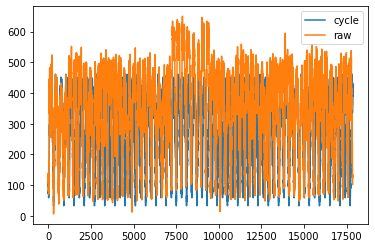

In [24]:
import numpy as np
import matplotlib.pyplot as plt


period = 600
cycle = []
for i in range(period):
    cycle.append(train[i::period,:,:].mean(axis=0))

cycle = np.array(cycle*(data.shape[0]//period)+cycle[:data.shape[0]%period])

plt.plot(cycle[:,0,0],label="cycle")
plt.plot(data[:,0,0],label="raw")
plt.legend()
cycle.shape

In [32]:
a = data[0:100]
b = cycle[100:200]
((b[0]-a[-1])/a[-1]).shape

(170, 1)